# What is the notebook about?

## Problem - Gridworld Environment Algorithms
This problem deals with a grid world and stochastic actions. The tasks you have to do are:
- Implement Policy Iteration
- Implement Value Iteration
- Implement TD lamdda
- Visualize the results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [1]:
!pip install aicrowd-cli > /dev/null 

ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


# AIcrowd Runtime Configuration 🧷

Get login API key from https://www.aicrowd.com/participants/me

In [2]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/a5562c7d-55f0-4d06-841c-110655bb04ec_a2_gridworld_inputs.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")


API Key valid
Saved API Key successfully!
a5562c7d-55f0-4d06-841c-110655bb04ec_a2_gridworld_inputs.zip: 100% 14.2k/14.2k [00:00<00:00, 635kB/s]


In [4]:
!unzip -q $AICROWD_DATASET_PATH

In [5]:
DATASET_DIR = 'inputs/'

# GridWorld Environment
Read the code for the environment thoroughly

Do not edit the code for the environment

In [54]:
import numpy as np

class GridEnv_HW2:
    def __init__(self, 
                 goal_location, 
                 action_stochasticity,
                 non_terminal_reward,
                 terminal_reward,
                 grey_in,
                 brown_in,
                 grey_out,
                 brown_out
                ):

        # Do not edit this section 
        self.action_stochasticity = action_stochasticity
        self.non_terminal_reward = non_terminal_reward
        self.terminal_reward = terminal_reward
        self.grid_size = [10, 10]

        # Index of the actions 
        self.actions = {'N': (1, 0), 
                        'E': (0,1),
                        'S': (-1,0), 
                        'W': (0,-1)}
        
        self.perpendicular_order = ['N', 'E', 'S', 'W']
        
        l = ['normal' for _ in range(self.grid_size[0]) ]
        self.grid = np.array([l for _ in range(self.grid_size[1]) ], dtype=object)

        self.grid[goal_location[0], goal_location[1]] = 'goal'
        self.goal_location = goal_location

        for gi in grey_in:
            self.grid[gi[0],gi[1]] = 'grey_in'
        for bi in brown_in:    
            self.grid[bi[0], bi[1]] = 'brown_in'

        for go in grey_out:    
            self.grid[go[0], go[1]] = 'grey_out'
        for bo in brown_out:    
            self.grid[bo[0], bo[1]] = 'brown_out'

        self.grey_outs = grey_out
        self.brown_outs = brown_out

    def _out_of_grid(self, state):
        if state[0] < 0 or state[1] < 0:
            return True
        elif state[0] > self.grid_size[0] - 1:
            return True
        elif state[1] > self.grid_size[1] - 1:
            return True
        else:
            return False

    def _grid_state(self, state):
        return self.grid[state[0], state[1]]        
        
    def get_transition_probabilites_and_reward(self, state, action):
        """ 
        Returns the probabiltity of all possible transitions for the given action in the form:
        A list of tuples of (next_state, probability, reward)
        Note that based on number of state and action there can be many different next states
        Unless the state is All the probabilities of next states should add up to 1
        """

        grid_state = self._grid_state(state)
        
        if grid_state == 'goal':
            return [(self.goal_location, 1.0, 0.0)]
        elif grid_state == 'grey_in':
            npr = []
            for go in self.grey_outs:
                npr.append((go, 1/len(self.grey_outs), 
                            self.non_terminal_reward))
            return npr
        elif grid_state == 'brown_in':
            npr = []
            for bo in self.brown_outs:
                npr.append((bo, 1/len(self.brown_outs), 
                            self.non_terminal_reward))
            return npr
        
        direction = self.actions.get(action, None)
        if direction is None:
            raise ValueError("Invalid action %s , please select among" % action, list(self.actions.keys()))

        dir_index = self.perpendicular_order.index(action)
        wrap_acts = self.perpendicular_order[dir_index:] + self.perpendicular_order[:dir_index]
        next_state_probs = {}
        for prob, a in zip(self.action_stochasticity, wrap_acts):
            d = self.actions[a]
            next_state = (state[0] + d[0]), (state[1] + d[1])
            if self._out_of_grid(next_state):
                next_state = state
            next_state_probs.setdefault(next_state, 0.0)
            next_state_probs[next_state] += prob

        npr = []
        for ns, prob in next_state_probs.items():
            next_grid_state = self._grid_state(ns)
            reward = self.terminal_reward if next_grid_state == 'goal' else self.non_terminal_reward
            npr.append((ns, prob, reward))

        return npr

    def step(self, state, action):
        npr = self.get_transition_probabilites_and_reward(state, action)
        probs = [t[1] for t in npr]
        sampled_idx = np.random.choice(range(len(npr)), p=probs)
        sampled_npr = npr[sampled_idx]
        next_state = sampled_npr[0]
        reward = sampled_npr[2]
        is_terminal = next_state == tuple(self.goal_location)
        return next_state, reward, is_terminal

## Example environment

This has the same setup as the pdf, do not edit the settings

In [55]:
def get_base_kwargs():
    goal_location = (9,9)
    action_stochasticity = [0.8, 0.2/3, 0.2/3, 0.2/3]
    grey_out = [(3,2), (4,2), (5,2), (6,2)]
    brown_in = [(9,7)]
    grey_in = [(0,0)]
    brown_out = [(1,7)]
    non_terminal_reward = 0
    terminal_reward = 10

    base_kwargs =  {"goal_location": goal_location, 
            "action_stochasticity": action_stochasticity,
            "brown_in": brown_in, 
            "grey_in": grey_in, 
            "brown_out": brown_out,
            "non_terminal_reward": non_terminal_reward,
            "terminal_reward": terminal_reward,
            "grey_out": grey_out,}
    
    return base_kwargs

base_kwargs = get_base_kwargs()

## Task 2.1 - Value Iteration
Run value iteration on the environment and generate the policy and expected reward

In [45]:
import time
import matplotlib.pyplot as plt

def calculate_error(J, Jv, row_size, col_size):
    num_squared = 0
    for row_iter in np.arange(row_size):
        for col_iter in np.arange(col_size):
            num_squared += (J[row_iter, col_iter] - Jv[row_iter, col_iter]) ** 2
    
    error_ms = num_squared / ( row_size * col_size )
    error_rms = pow(error_ms, 0.5)
    return error_rms

def value_iteration(env, gamma):
    # Initial Values
    values = np.zeros((10, 10))

    # Initial policy
    policy = np.empty((10, 10), object)
    policy[:] = 'N' # Make all the policy values as 'N'

    # Begin code here
    H_values = np.zeros((10, 10))
    tol = 1e-8
    delta = 0.0
    value_iter = 0
    inner_value_iter = 0
    max_iter = 1000
    use_max_iter = False
    time_start = time.time()

    row_size, col_size = env.grid_size[0], env.grid_size[1]

    loc_grey_in = np.where(env.grid == 'grey_in')
    loc_brown_in = np.where(env.grid == 'brown_in')
    loc_grey_out = np.where(env.grid == 'grey_out')
    loc_brown_out = np.where(env.grid == 'brown_out')

    state_grey_in = loc_grey_in[0][0], loc_grey_in[1][0]
    state_brown_in = loc_brown_in[0][0], loc_brown_in[1][0]
    state_grey_out = loc_grey_out[0][0], loc_grey_out[1][0]
    state_brown_out = loc_brown_out[0][0], loc_brown_out[1][0]

    values_state_grey_in = []
    values_state_brown_in = []
    values_state_grey_out = []
    values_state_brown_out = []
    value_iters = []

    while True:

        delta = 0.0

        for row_iter in np.arange(row_size):
            for col_iter in np.arange(col_size):
                current_state = [row_iter, col_iter]
                action_values_at_state = []

                for current_action in env.actions:
                    #get prob, rew for next states given current state and action
                    nextstate_prob_rews = env.get_transition_probabilites_and_reward(tuple((row_iter, col_iter)), current_action)
                    res = list(zip(*nextstate_prob_rews))
                    next_states, probs, rews = list(res[0]), list(res[1]), list(res[2])

                    value_prev = np.zeros((1, len(next_states)))
                    for next_state_iter in np.arange(len(next_states)):
                        next_state = next_states[next_state_iter]
                        value_prev[0, next_state_iter] = values[next_state[0], next_state[1]]

                    ### find the expected value for a given state and action - it's a dot product of transition probabilities and ( reward + values from previous iterations )
                    expected_value_action = np.dot(probs, list(np.add(rews, np.asarray(gamma) * list(value_prev[0]))))
                    action_values_at_state.append(expected_value_action)
                    inner_value_iter += 1

                ### given a state - find the max value across all actions 
                H_values[row_iter, col_iter] = np.amax(action_values_at_state)
                policy[row_iter, col_iter] = env.perpendicular_order[np.argmax(list(action_values_at_state))]

                ### update delta as the current max of delta and the change
                delta = max(delta, abs(H_values[row_iter, col_iter] - values[row_iter, col_iter]))
        
        #update J from H
        # for row_iter in np.arange(row_size):
        #     for col_iter in np.arange(col_size):
        #         values[row_iter, col_iter] = H_values[row_iter, col_iter]
        values = H_values.copy()

        value_iter += 1
        value_iters.append(value_iter)
        values_state_grey_in.append(values[state_grey_in])
        values_state_brown_in.append(values[state_brown_in])
        values_state_grey_out.append(values[state_grey_out])
        values_state_brown_out.append(values[state_brown_out])
        # print("VI, iter = ", value_iter, ", value = ", values[state_fixed])
        ### break the loop when delta is less than the tolerance
        if ( delta < tol or (use_max_iter and value_iter > max_iter)):
            break

    time_end = time.time()
    print("VI, gamma = ", gamma, ", iter = ", value_iter, ", time = %.2f"% (time_end-time_start), ", policy = ", policy)

    # Put your extra information needed for plots etc in this dictionary
    extra_info = {'grey_in' : values_state_grey_in, 
    'brown_in' : values_state_brown_in,
    'grey_out' : values_state_grey_out,
    'brown_out' : values_state_brown_out,
    'iters' : value_iters}

    # End code

    # Do not change the number of output values
    return {"Values": values, "Policy": policy}, extra_info

In [56]:
env = GridEnv_HW2(**base_kwargs)
res_vi, extra_info_vi = value_iteration(env, 0.7)

 # The rounding off is just for making print statement cleaner
print(np.flipud(np.round(res_vi['Values'], decimals=2)))
print(np.flipud(res_vi['Policy']))

VI, gamma =  0.7 , iter =  40 , time = 0.79 , policy =  [['N' 'W' 'W' 'E' 'E' 'E' 'E' 'N' 'N' 'N']
 ['S' 'S' 'E' 'E' 'E' 'E' 'N' 'N' 'N' 'N']
 ['S' 'N' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'N']
 ['N' 'N' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'N']
 ['N' 'E' 'E' 'E' 'E' 'E' 'N' 'N' 'N' 'N']
 ['N' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N']
 ['E' 'E' 'E' 'E' 'E' 'S' 'S' 'N' 'E' 'N']]
[[0.1  0.15 0.24 0.37 0.56 0.86 1.29 0.12 8.68 0.  ]
 [0.13 0.2  0.31 0.5  0.81 1.31 2.12 3.43 5.75 8.95]
 [0.1  0.16 0.25 0.39 0.62 0.97 1.52 2.38 3.7  5.61]
 [0.07 0.11 0.17 0.26 0.41 0.64 0.99 1.54 2.38 3.52]
 [0.05 0.07 0.11 0.17 0.27 0.41 0.64 0.99 1.53 2.21]
 [0.03 0.05 0.07 0.11 0.17 0.27 0.41 0.64 0.98 1.39]
 [0.02 0.03 0.05 0.07 0.11 0.17 0.27 0.41 0.63 0.87]
 [0.03 0.02 0.03 0.05 0.07 0.11 0.17 0.27 0.4  0.55]
 [0.04 0.03 0.02 0.03 0.05 0.07 0.11 0.17 0.26 0.35]
 [0.07 0.04 0.03 0.02 0.03 0.05 0.07

## Task 2.2 - Policy Iteration
Run policy iteration on the environment and generate the policy and expected reward

In [57]:
def policy_iteration(env, gamma):
    # Initial Values
    values = np.zeros((10, 10))

    # Initial policy
    policy = np.empty((10, 10), object)
    policy[:] = 'N' # Make all the policy values as 'N'

    # Begin code here   

    tol = 1e-8
    delta = 0.0
    policy_iter = 0
    time_start = time.time()
    row_size, col_size = env.grid_size[0], env.grid_size[1]

    error_rmses = []

    loc_grey_in = np.where(env.grid == 'grey_in')
    loc_brown_in = np.where(env.grid == 'brown_in')
    loc_grey_out = np.where(env.grid == 'grey_out')
    loc_brown_out = np.where(env.grid == 'brown_out')

    state_grey_in = loc_grey_in[0][0], loc_grey_in[1][0]
    state_brown_in = loc_brown_in[0][0], loc_brown_in[1][0]
    state_grey_out = loc_grey_out[0][0], loc_grey_out[1][0]
    state_brown_out = loc_brown_out[0][0], loc_brown_out[1][0]

    values_state_grey_in = []
    values_state_brown_in = []
    values_state_grey_out = []
    values_state_brown_out = []
    policy_iters = []
    
    #external while loop to find optimal policy
    while True:
        #internal while loop, value function estimation for a fixed policy
        while True:
            delta = 0.0

            for row_iter in np.arange(row_size):
                for col_iter in np.arange(col_size):
                    #store value at current state before updating it
                    j = values[row_iter, col_iter]

                    #find action at current state from the policy map
                    current_action  = policy[row_iter, col_iter]

                    #get prob, rew for next states given current state and action
                    nextstate_prob_rews = env.get_transition_probabilites_and_reward(tuple((row_iter, col_iter)), current_action)
                    res = list(zip(*nextstate_prob_rews))
                    next_states, probs, rews = list(res[0]), list(res[1]), list(res[2])

                    value_prev = np.zeros((1, len(next_states)))
                    for next_state_iter in np.arange(len(next_states)):
                        next_state = next_states[next_state_iter]
                        value_prev[0, next_state_iter] = values[next_state[0], next_state[1]]

                    ### find the expected value for a given state and action - it's a dot product of transition probabilities and ( reward + values from previous iterations )
                    values[row_iter, col_iter] = np.dot(probs, list(np.add(rews, np.asarray(gamma) * list(value_prev[0]))))

                    #update delta
                    delta = max(delta, abs(j - values[row_iter, col_iter]))
            
            ### break the loop when delta is less than the tolerance
            if ( delta < tol ):
                break

        #calculate optimal policy
        done = 1
        for row_iter in np.arange(row_size):
            for col_iter in np.arange(col_size):
                #b = PI(s), store the previous policy before it gets updated for current_state
                b = policy[row_iter, col_iter]

                #calculate values for all actions at current state and pick the argmax of them for optimal policy
                action_values_at_state = []
                for current_action in env.actions:
                    #get prob, rew for next states given current state and action
                    nextstate_prob_rews = env.get_transition_probabilites_and_reward(tuple((row_iter, col_iter)), current_action)
                    res = list(zip(*nextstate_prob_rews))
                    next_states, probs, rews = list(res[0]), list(res[1]), list(res[2])

                    value_prev = np.zeros((1, len(next_states)))
                    for next_state_iter in np.arange(len(next_states)):
                        next_state = next_states[next_state_iter]
                        value_prev[0, next_state_iter] = values[next_state[0], next_state[1]]

                    ### find the expected value for a given state and action - it's a dot product of transition probabilities and ( reward + values from previous iterations )
                    expected_value_action = np.dot(probs, list(np.add(rews, np.asarray(gamma) * list(value_prev[0]))))
                    action_values_at_state.append(expected_value_action)

                ### given a state - find the max value across all actions 
                policy[row_iter, col_iter] = env.perpendicular_order[np.argmax(list(action_values_at_state))]

                #compare previous to current policy and if any change occurs we are not done yet and need to do more iterations
                if(b != policy[row_iter, col_iter]):
                    done = 0
                
        policy_iter += 1
        policy_iters.append(policy_iter)
        values_state_grey_in.append(values[state_grey_in])
        values_state_brown_in.append(values[state_brown_in])
        values_state_grey_out.append(values[state_grey_out])
        values_state_brown_out.append(values[state_brown_out])
        error_rms = calculate_error(values, res_vi["Values"], 10, 10)
        error_rmses.append(error_rms)
        # print("PI, iter = ", policy_iter, ", value = ", values[state_fixed], ", error_rms = ",error_rms)
        if(done == 1):
            break

    time_end = time.time()
    print("PI, gamma = ", gamma, ", iter = ", policy_iter, ", time = %.2f"% (time_end-time_start), ", policy = ", policy)

    # Put your extra information needed for plots etc in this dictionary
    extra_info = {'grey_in' : values_state_grey_in, 
    'brown_in' : values_state_brown_in,
    'grey_out' : values_state_grey_out,
    'brown_out' : values_state_brown_out,
    'iters' : policy_iters,
    'rms_error' : error_rmses}


    # End code

    # Do not change the number of output values
    return {"Values": values, "Policy": policy}, extra_info

In [58]:
env = GridEnv_HW2(**base_kwargs)
res_pi, extra_info_pi = policy_iteration(env, 0.7)

# The rounding off is just for making print statement cleaner
print(np.flipud(np.round(res_pi['Values'], decimals=2)))
print(np.flipud(res_pi['Policy']))

PI, gamma =  0.7 , iter =  6 , time = 0.82 , policy =  [['N' 'W' 'W' 'E' 'E' 'E' 'E' 'N' 'N' 'N']
 ['S' 'S' 'E' 'E' 'E' 'E' 'N' 'N' 'N' 'N']
 ['S' 'N' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'N']
 ['N' 'N' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'N']
 ['N' 'E' 'E' 'E' 'E' 'E' 'N' 'N' 'N' 'N']
 ['N' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N']
 ['E' 'E' 'E' 'E' 'E' 'S' 'S' 'N' 'E' 'N']]
[[0.1  0.15 0.24 0.37 0.56 0.86 1.29 0.12 8.68 0.  ]
 [0.13 0.2  0.31 0.5  0.81 1.31 2.12 3.43 5.75 8.95]
 [0.1  0.16 0.25 0.39 0.62 0.97 1.52 2.38 3.7  5.61]
 [0.07 0.11 0.17 0.26 0.41 0.64 0.99 1.54 2.38 3.52]
 [0.05 0.07 0.11 0.17 0.27 0.41 0.64 0.99 1.53 2.21]
 [0.03 0.05 0.07 0.11 0.17 0.27 0.41 0.64 0.98 1.39]
 [0.02 0.03 0.05 0.07 0.11 0.17 0.27 0.41 0.63 0.87]
 [0.03 0.02 0.03 0.05 0.07 0.11 0.17 0.27 0.4  0.55]
 [0.04 0.03 0.02 0.03 0.05 0.07 0.11 0.17 0.26 0.35]
 [0.07 0.04 0.03 0.02 0.03 0.05 0.07 

# Task 2.3 - TD Lambda

Use the heuristic policy and implement TD lambda to find values on the gridworld

In [59]:
# The policy mentioned in the pdf to be used for TD lambda, do not modify this
def heuristic_policy(env, state):
    goal = env.goal_location
    dx = goal[0] - state[0]
    dy = goal[1] - state[1]
    if abs(dx) >= abs(dy):
        direction = (np.sign(dx), 0)
    else:
        direction = (0, np.sign(dy))
    for action, dir_val in env.actions.items():
        if dir_val == direction:
            target_action = action
            break
    return target_action

In [60]:
def td_lambda(env, lamda, seeds):
    alpha = 0.5
    gamma = 0.7
    N = len(seeds)
    # Usage of input_policy
    # heuristic_policy(env, state) -> action
    example_action = heuristic_policy(env, (1,2)) # Returns 'N' if goal is (9,9)

    # Example of env.step
    # env.step(state, action) -> Returns next_state, reward, is_terminal

    # Initial values
    values = np.zeros((10, 10))
    es = np.zeros((10,10))

    time_start = time.time()
    error_rmses = []
    avg_error_rmses = []
    iters = []

    iter = 0
    grey_in_loc = np.where(env.grid == 'grey_in')
    orig_state = grey_in_loc[0][0], grey_in_loc[1][0]

    for episode_idx in range(N):
         # Do not change this else the results will not match due to environment stochas
        np.random.seed(seeds[episode_idx])
        grey_in_loc = np.where(env.grid == 'grey_in')
        state = grey_in_loc[0][0], grey_in_loc[1][0]
        done = False
        avg_error = 0
        while not done:
            action = heuristic_policy(env, state)
            ns, rew, is_terminal = env.step(state, action) 
            # env.step is already taken inside the loop for you, 
            # Don't use env.step anywhere else in your code

            # Begin code here
            delta = rew + gamma * values[ns] - values[state]
            es[state] = es[state] + 1

            # vectorize to speed up
            values = values + alpha * delta * es
            es = gamma * lamda * es

            state = ns
            iter += 1
            if(is_terminal):
                done = True
                
        error_rms = calculate_error(values, res_vi["Values"], 10, 10)
        avg_error += error_rms
        # if((episode_idx + 1) % 25 == 0):
        error_rmses.append(error_rms)
        iters.append(episode_idx)
            # avg_error = avg_error / 25
            # avg_error_rmses.append(avg_error)
        # print("TDLamda, episode_idx = ", episode_idx, ",  error_rms = ",error_rms)
                
    time_end = time.time()

    print("TDLambda, lamda = ", lamda, ", iter = ", iter, ", time = %.2f"% (time_end-time_start), ", values = ", values[orig_state])

    # Put your extra information needed for plots etc in this dictionary
    extra_info = (error_rmses, iters)

    # End code

    # Do not change the number of output values
    return {"Values": values}, extra_info

In [61]:
env = GridEnv_HW2(**base_kwargs)
res_td, extra_info = td_lambda(env, lamda=0.5, seeds=np.arange(1000))

 # The rounding off is just for making print statement cleaner
print(np.flipud(np.round(res_td['Values'], decimals=2)))

TDLambda, lamda =  0.5 , iter =  19076 , time = 1.43 , values =  0.11706517510959256
[[ 0.    0.    0.01  0.02  0.03  0.06  0.08  0.11 10.    0.  ]
 [ 0.    0.    0.04  0.18  0.91  1.4   1.28  4.85  6.98  9.92]
 [ 0.    0.05  0.24  0.42  0.63  0.71  2.08  3.28  3.8   5.89]
 [ 0.02  0.08  0.21  0.31  0.48  0.82  1.29  1.66  2.2   3.39]
 [ 0.02  0.07  0.08  0.11  0.25  0.4   0.52  0.96  1.62  1.44]
 [ 0.02  0.04  0.05  0.1   0.16  0.23  0.38  0.57  1.08  0.97]
 [ 0.01  0.03  0.03  0.05  0.08  0.17  0.2   0.35  0.58  0.26]
 [ 0.    0.01  0.03  0.03  0.07  0.1   0.15  0.23  0.18  0.18]
 [ 0.    0.    0.01  0.01  0.03  0.03  0.1   0.15  0.16  0.  ]
 [ 0.12  0.    0.    0.    0.    0.01  0.01  0.11  0.13  0.  ]]


# Task 2.4 - TD Lamdba for multiple values of $\lambda$

Ideally this code should run as is

In [62]:
# This cell is only for your subjective evaluation results, display the results as asked in the pdf
# You can change it as you require, this code should run TD lamdba by default for different values of lambda

lamda_values = np.arange(0, 100+5, 5)/100
td_lamda_results = {}
extra_info = {}
for lamda in lamda_values:
    env = GridEnv_HW2(**base_kwargs)
    td_lamda_results[lamda], extra_info[lamda] = td_lambda(env, lamda,
                                                           seeds=np.arange(1000))

TDLambda, lamda =  0.0 , iter =  19076 , time = 1.56 , values =  0.11220578033298932
TDLambda, lamda =  0.05 , iter =  19076 , time = 1.56 , values =  0.11116585741978822
TDLambda, lamda =  0.1 , iter =  19076 , time = 1.76 , values =  0.11005529157238976
TDLambda, lamda =  0.15 , iter =  19076 , time = 1.74 , values =  0.10907956102742684
TDLambda, lamda =  0.2 , iter =  19076 , time = 1.75 , values =  0.10840080331692681
TDLambda, lamda =  0.25 , iter =  19076 , time = 1.54 , values =  0.1081501504931559
TDLambda, lamda =  0.3 , iter =  19076 , time = 1.63 , values =  0.10843920499053794
TDLambda, lamda =  0.35 , iter =  19076 , time = 1.60 , values =  0.10937029776682163
TDLambda, lamda =  0.4 , iter =  19076 , time = 1.74 , values =  0.11104510935078375
TDLambda, lamda =  0.45 , iter =  19076 , time = 1.52 , values =  0.11357111524019228
TDLambda, lamda =  0.5 , iter =  19076 , time = 1.57 , values =  0.11706517510959256
TDLambda, lamda =  0.55 , iter =  19076 , time = 1.58 , value

# Generate Results ✅

In [63]:
def get_results(kwargs):

    gridenv = GridEnv_HW2(**kwargs)

    policy_iteration_results = policy_iteration(gridenv, 0.7)[0]
    value_iteration_results = value_iteration(gridenv, 0.7)[0]
    td_lambda_results = td_lambda(env, 0.5, np.arange(1000))[0]

    final_results = {}
    final_results["policy_iteration"] = policy_iteration_results
    final_results["value_iteration"] = value_iteration_results
    final_results["td_lambda"] = td_lambda_results

    return final_results

In [64]:
# Do not edit this cell, generate results with it as is
if not os.path.exists(AICROWD_RESULTS_DIR):
    os.mkdir(AICROWD_RESULTS_DIR)

for params_file in os.listdir(DATASET_DIR):
  kwargs = np.load(os.path.join(DATASET_DIR, params_file), allow_pickle=True).item()
  results = get_results(kwargs)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

PI, gamma =  0.7 , iter =  4 , time = 0.67 , policy =  [['E' 'E' 'E' 'E' 'N' 'N' 'E' 'E' 'E' 'N']
 ['E' 'E' 'E' 'E' 'N' 'N' 'E' 'E' 'N' 'N']
 ['E' 'E' 'E' 'N' 'N' 'N' 'S' 'N' 'N' 'N']
 ['E' 'E' 'N' 'N' 'N' 'N' 'N' 'W' 'N' 'N']
 ['E' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['W' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['W' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['W' 'W' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'N']
 ['W' 'W' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'N']]
VI, gamma =  0.7 , iter =  50 , time = 1.25 , policy =  [['E' 'E' 'E' 'E' 'N' 'N' 'E' 'E' 'E' 'N']
 ['E' 'E' 'E' 'E' 'N' 'N' 'E' 'E' 'N' 'N']
 ['E' 'E' 'E' 'N' 'N' 'N' 'S' 'N' 'N' 'N']
 ['E' 'E' 'N' 'N' 'N' 'N' 'N' 'W' 'N' 'N']
 ['E' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['W' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['W' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['W' 'W' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'N']
 ['W' 'W' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'N']]
TDLambda, lamda =  0.5 , it

# Check your score on the public data

This scores is not your final score, and it doesn't use the marks weightages. This is only for your reference of how arrays are matched and with what tolerance.

In [65]:
# Check your score on the given test cases (There are more private test cases not provided)
target_folder = 'targets'
result_folder = AICROWD_RESULTS_DIR

def check_algo_match(results, targets):
    if 'Policy' in results:
        policy_match = results['Policy'] == targets['Policy']
    else:
        policy_match = True
    # Reference https://numpy.org/doc/stable/reference/generated/numpy.allclose.html
    rewards_match = np.allclose(results['Values'], targets['Values'], rtol=1e-3)
    equal = rewards_match and policy_match
    return equal

def check_score(target_folder, result_folder):
    match = []
    for out_file in os.listdir(result_folder):
        res_file = os.path.join(result_folder, out_file)
        results = np.load(res_file, allow_pickle=True).item()
        idx = out_file.split('_')[-1][:-4]  # Extract the file number
        target_file = os.path.join(target_folder, f"targets_{idx}.npy")
        targets = np.load(target_file, allow_pickle=True).item()
        algo_match = []
        for k in targets:
            algo_results = results[k]
            algo_targets = targets[k]
            algo_match.append(check_algo_match(algo_results, algo_targets))
        match.append(np.mean(algo_match))
    return np.mean(match)

if os.path.exists(target_folder):
    print("Shared data Score (normalized to 1):", check_score(target_folder, result_folder))

Shared data Score (normalized to 1): 1.0


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## Display Results of TD lambda 
Display Results of TD lambda with lambda values from 0 to 1 with steps of 0.05

Add code/text as required


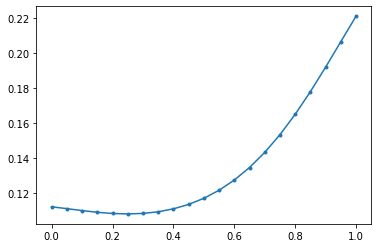

In [66]:
grey_in_loc = np.where(env.grid == 'grey_in')
grey_in_state = grey_in_loc[0][0], grey_in_loc[1][0]

values_td_lamda_seq = []
for lamda in lamda_values:
    values_td_lamda_state = td_lamda_results[lamda]["Values"][grey_in_state]
    values_td_lamda_seq.append(values_td_lamda_state)

plt.plot(lamda_values, values_td_lamda_seq, label = "grey state value", marker =".")


# Subjective questions



## 2.a Value Iteration vs Policy Iteration


1.   Compare value iteration and policy iteration for states Brown in, Brown Out, Grey out and Grey In 
2.   Which one converges faster and why






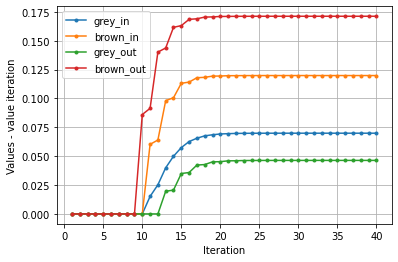

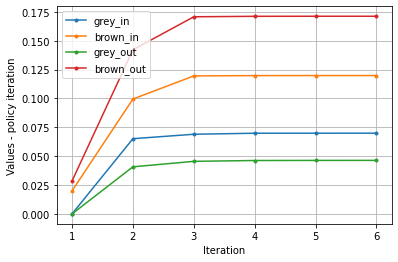

In [67]:
plt.plot(extra_info_vi["iters"], extra_info_vi["grey_in"], label = "grey_in", marker =".")
plt.plot(extra_info_vi["iters"], extra_info_vi["brown_in"], label = "brown_in", marker =".")
plt.plot(extra_info_vi["iters"], extra_info_vi["grey_out"], label = "grey_out", marker =".")
plt.plot(extra_info_vi["iters"], extra_info_vi["brown_out"], label = "brown_out", marker =".")

plt.legend(loc = "upper left")
plt.xlabel('Iteration')
plt.ylabel('Values - value iteration')
plt.grid()
plt.show()

plt.plot(extra_info_pi["iters"], extra_info_pi["grey_in"], label = "grey_in", marker =".")
plt.plot(extra_info_pi["iters"], extra_info_pi["brown_in"], label = "brown_in", marker =".")
plt.plot(extra_info_pi["iters"], extra_info_pi["grey_out"], label = "grey_out", marker =".")
plt.plot(extra_info_pi["iters"], extra_info_pi["brown_out"], label = "brown_out", marker =".")

plt.legend(loc = "upper left")
plt.xlabel('Iteration')
plt.ylabel('Values - policy iteration')
plt.grid()
plt.show()

2. Policy iteration converges faster than value iteration in terms of number of iterations in the outer loop as policy-space ( finite ) is much smaller compared to value space to iterate in.

## 2.b How changing $\lambda$ affecting TD Lambda

Core Idea - 
Lambda = 0 means 1-step return gets the full weight in TD-Lambda algorithm, which implies the TD-errors will propagate slowly. Lambda = 1 means the infinity-step return ( or Terminal or MC return ) gets full weight while all other n-step returns 0 weight, it implies that the TD-error propagates faster for episodes with only terminal rewards.
But for intemediate rewards during an episode, lambda values between 0 and 1 perform better at propagating TD-errors and therefore learning.

Observation - 
We can observe that lambda = 0 or 1 achieve worse RMS-error, when plotted against no. of iterations, compared to intermediate lambdas which achieve lower RMS errors eventually. The RMS error rate goes down more slowly for lambda = 1 or 0 which is consistent with our assumption above.


## 2.c Policy iteration error curve
Plot error curve of $J_i$ vs iteration $i$ for policy iteration

No handles with labels found to put in legend.


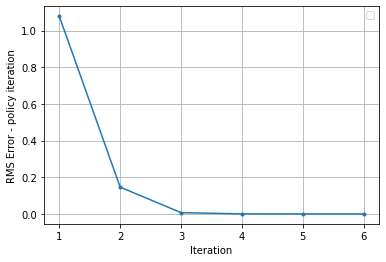

In [69]:
plt.plot(extra_info_pi['iters'], extra_info_pi['rms_error'], label = "", marker =".")

plt.legend(loc = "upper right")
plt.xlabel('Iteration')
plt.ylabel('RMS Error - policy iteration')
plt.grid()
plt.show()

## 2.d TD Lamdba error curve
Plot error curve of $J_i$ vs iteration $i$ for TD Lambda for $\lambda = [0, 0.25, 0.5, 0.75, 1]$

TDLambda, lamda =  0.0 , iter =  19076 , time = 1.46 , values =  0.11220578033298932
TDLambda, lamda =  0.25 , iter =  19076 , time = 1.58 , values =  0.1081501504931559
TDLambda, lamda =  0.5 , iter =  19076 , time = 1.48 , values =  0.11706517510959256
TDLambda, lamda =  0.75 , iter =  19076 , time = 1.81 , values =  0.15336555111720382
TDLambda, lamda =  1.0 , iter =  19076 , time = 1.53 , values =  0.2209454022730491


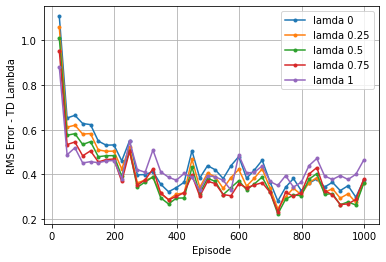

In [34]:
# the error graph will be smooth for smaller values of alpha like 0.1 instead of the default value used here 0.5
# it will also be smooth if we plot the average of last few episodes instead of plotting the actual error at i'th episode
# it does not make sense to plot all 1000 points as that makes the graph look cluttered, so we will choose episode_gap_plotting = 25 by default
# which means we pick and plot the error every 25 episodes.

lamda_values = np.arange(0, 105, 25)/100
td_lamda_results = {}
extra_info = {}
seeds = np.arange(1000)
episode_gap_plotting = 25 # if we plot the whole 1000 iterations for each lambda the graph looks quite messy
plot_avg = False # whether to plot the average error of last #episode_gap_plotting episodes
for lamda in lamda_values:
    env = GridEnv_HW2(**base_kwargs)
    td_lamda_results[lamda], (errors_orig, iters_orig) = td_lambda(env, lamda,
                                                           seeds=seeds)

    # (extra_info[lamda], iters)
    errors1 = []
    iters1 = []
    for it in iters_orig:
        if((it+1) % episode_gap_plotting == 0):
            if(plot_avg):
                errors1.append(np.mean(errors_orig[max(0, it-episode_gap_plotting):(it+1)]))
            else:
                errors1.append(errors_orig[it])
            iters1.append(it)

    extra_info[lamda] = errors1.copy()
    iters = iters1.copy()

plt.plot(iters, extra_info[0], label = "lamda 0", marker =".")
plt.plot(iters, extra_info[0.25], label = "lamda 0.25", marker =".")
plt.plot(iters, extra_info[0.5], label = "lamda 0.5", marker =".")
plt.plot(iters, extra_info[0.75], label = "lamda 0.75", marker =".")
plt.plot(iters, extra_info[1], label = "lamda 1", marker =".")

plt.legend(loc = "upper right")
plt.xlabel('Episode')
plt.ylabel('RMS Error - TD Lambda')
plt.grid()
plt.show()


# Submit to AIcrowd 🚀

In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH aicrowd notebook submit --no-verify -c iit-m-rl-assignment-2-gridworld -a assets

No jupyter lab module found. Using jupyter notebook.
Using notebook: /content/Copy%20of%20IITM_Assignment_2_Gridworld_Release.ipynb for submission...
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
